<a href="https://colab.research.google.com/github/zrruziev/deep_learning_practice/blob/main/TENSORFLOW/English_to_Spanish_translation_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English-to-Spanish translation with a sequence-to-sequence Transformer

[Official Link](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/) 
| [Read more about transformers...](https://vaclavkosar.com/)

## Introduction
In this example, we'll build a sequence-to-sequence Transformer model, which we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer, and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book `Deep Learning with Python, Second Edition` (chapter 11: Deep learning for text). The present example is fairly barebones, so for detailed explanations of how each building block works, as well as the theory behind Transformers, I recommend reading the book.

In [ ]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

## Downloading the data

We'll be working with an English-to-Spanish translation dataset provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [ ]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

2638744/2638744 [==============================] - 0s 0us/step


## Parsing the data
Each line contains an English sentence and its corresponding Spanish sentence. The English sentence is the source sequence and Spanish one is the target sequence. We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

Here's what our sentence pairs look like:

In [ ]:
for _ in range(5):
    print(random.choice(text_pairs))

('When I was a little boy, I often went fishing with my brother in the river.', '[start] Cuando era niño, iba mucho a pescar al río con mi hermano. [end]')
("My father's car is new.", '[start] El auto de mi padre es nuevo. [end]')
('How big is the team?', '[start] ¿Qué tan grande es el equipo? [end]')
("I don't know what I should've done.", '[start] No sé que debía haber hecho. [end]')
('She told him to rewrite his resume.', '[start] Ella le dijo que reescribiera su resumen. [end]')


<br>Now, let's split the sentence pairs into a training set, a validation set, and a test set.

In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


## Vectorizing the text data
We'll use two instances of the `TextVectorization` layer to vectorize the text data (one for English and one for Spanish), that is to say, to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters) and splitting scheme (split on whitespace), while the Spanish layer will use a custom standardization, where we add the character `"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend stripping the punctuation characters in either language. Instead, I would recommend turning each punctuation character into its own token, which you could achieve by providing a custom split function to the `TextVectorization` layer.

In [ ]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 20
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(max_tokens=vocab_size,
                                      output_mode="int",
                                      output_sequence_length=sequence_length)

spa_vectorization = TextVectorization(max_tokens=vocab_size,
                                      output_mode="int",
                                      output_sequence_length=sequence_length + 1,
                                      standardize=custom_standardization)

train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

In [ ]:
print(f"\n\t\t\t======== train_eng_texts sample ========\n\n{train_eng_texts[:10]}")
print(f"\n\t\t\t======== train_spa_texts sample ========\n\n{train_spa_texts[:10]}\n")


			======== train_eng_texts sample ========

['The walls are covered with blood.', "Tom can't come to the office today.", 'I had an argument with Tom about the use of marijuana.', 'We met last week.', 'Tom has a solution for everything.', 'Tom is a very kind and generous man.', 'There is a boy near the door.', 'Tom is my stepdad.', 'Tom knows what he has to do.', "Tom didn't believe what Mary said."]

			======== train_spa_texts sample ========

['[start] Las paredes están cubiertas de sangre. [end]', '[start] Tom no puede venir a la oficina hoy. [end]', '[start] Discutí con Tom sobre el uso de la marihuana. [end]', '[start] Nos conocimos la semana pasada. [end]', '[start] Tom tiene una solución para todo. [end]', '[start] Tom es un hombre muy amable y generoso. [end]', '[start] Hay un chico cerca de la puerta. [end]', '[start] Tom es mi padrastro. [end]', '[start] Tom sabe lo que tiene que hacer. [end]', '[start] Tom no creyó lo que dijo Mary. [end]']



In [ ]:
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [ ]:
print(f"\n\t\t\t======== train_eng_texts voab ========\n\n{eng_vectorization.get_vocabulary()}")


			======== train_eng_texts voab ========

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he', 'in', 'of', 'that', 'it', 'was', 'do', 'this', 'me', 'have', 'my', 'for', 'she', 'dont', 'are', 'what', 'his', 'we', 'your', 'mary', 'on', 'be', 'with', 'want', 'not', 'im', 'and', 'at', 'like', 'know', 'him', 'can', 'go', 'her', 'has', 'will', 'its', 'they', 'there', 'time', 'how', 'did', 'as', 'very', 'were', 'had', 'all', 'about', 'up', 'here', 'didnt', 'think', 'when', 'from', 'get', 'out', 'cant', 'if', 'an', 'no', 'one', 'by', 'doesnt', 'why', 'would', 'going', 'see', 'come', 'ill', 'good', 'please', 'been', 'who', 'youre', 'just', 'so', 'need', 'more', 'help', 'where', 'than', 'tell', 'but', 'some', 'am', 'too', 'never', 'now', 'us', 'got', 'something', 'last', 'day', 'take', 'ive', 'much', 'should', 'money', 'car', 'could', 'work', 'home', 'people', 'well', 'back', 'book', 'told', 'said', 'really', 'many', 'went', 'our', 'house', 'anything', 'isnt', 'any', 'french', 'lot',

In [ ]:
print(f"\n\t\t\t======== train_spa_texts vocab ========\n\n{spa_vectorization.get_vocabulary()}\n")


			======== train_spa_texts vocab ========

['', '[UNK]', '[start]', '[end]', 'de', 'que', 'a', 'no', 'tom', 'la', 'el', 'en', 'es', 'un', 'me', 'se', 'por', 'lo', 'una', 'su', 'los', 'Él', 'está', 'mi', 'con', 'le', 'qué', 'ella', 'te', 'para', 'mary', 'y', 'las', 'más', 'al', 'yo', 'tu', 'estoy', 'muy', 'este', 'eso', 'tiene', 'esta', 'del', 'él', 'quiero', 'estaba', 'tengo', 'fue', 'si', 'casa', 'aquí', 'hacer', 'como', 'puedo', 'esto', 'todo', 'algo', 'tiempo', 'hay', 'ha', 'son', 'gusta', 'favor', 'todos', 'tan', 'nada', 'cuando', 'ir', 'vez', 'era', 'puede', 'he', 'bien', 'mucho', 'ellos', 'ser', 'nos', 'sé', 'solo', 'nunca', 'mañana', 'dos', 'estás', 'trabajo', 'sus', 'dónde', 'cómo', 'ya', 'tienes', 'dijo', 'creo', 'ahora', 'quién', 'dinero', 'pero', 'hablar', 'tomás', 'hace', 'siempre', 'ese', 'libro', 'están', 'día', 'tú', 'soy', 'puedes', 'hoy', 'voy', 'había', 'quiere', 'verdad', 'años', 'mejor', 'va', 'poco', 'quieres', 'tarde', 'esa', 'francés', 'estar', 'nadie', 'ver', 

<br>Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond) using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`. `encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far", that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step: it provides the next words in the target sentence -- what the model will try to predict.


In [ ]:
def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes (we have batches of 64 pairs, and all sequences are 20 steps long):

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


In [ ]:
num_of_sample = 5
test_dim = 10
for inputs, targets in train_ds.take(1):
    print(f"\t\t======== Encoder Inputs ========\n{inputs['encoder_inputs'][:num_of_sample, :test_dim]}")
    print(f"\n\t\t======== Decoder Inputs ========\n{inputs['decoder_inputs'][:num_of_sample, :test_dim]}")
    print(f"\n\t\t======== Target Inputs ========\n{targets[:num_of_sample, :test_dim]}")

		======== Encoder Inputs ========
[[   15     5   215    10  1698     0     0     0     0     0]
 [    6  3190     4    28     0     0     0     0     0     0]
 [  278 10843    38    49     4   197   718     0     0     0]
 [    9  5327    57    25  1217    35  3190     4    42     0]
 [   16     8     7   425    56  1823     0     0     0     0]]

		======== Decoder Inputs ========
[[   2  440  136   11   20 2008    3    0    0    0]
 [   2    8   15   25 2600    6   30    3    0    0]
 [   2  227    7  123  607  702    3    0    0    0]
 [   2   21 3096 1126   31   15 2600    6   27    3]
 [   2   42   12   18  301  143   32 2010    3    0]]

		======== Target Inputs ========
[[ 440  136   11   20 2008    3    0    0    0    0]
 [   8   15   25 2600    6   30    3    0    0    0]
 [ 227    7  123  607  702    3    0    0    0    0]
 [  21 3096 1126   31   15 2600    6   27    3    0]
 [  42   12   18  301  143   32 2010    3    0    0]]


## Building the model
Our sequence-to-sequence Transformer consists of a `TransformerEncoder` and a `TransformerDecoder` chained together. To make the model aware of word order, we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`, which will produce a new representation of it. This new representation will then be passed to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N). The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking (see method `get_causal_attention_mask()` on the `TransformerDecoder`). The `TransformerDecoder` sees the entire sequences at once, and thus we must make sure that it only uses information from target tokens 0 to N when predicting token N+1 (otherwise, it could use information from the future, which would result in a model that cannot be used at inference time).



In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)



class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)




class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

Next, we assemble the end-to-end model.

In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [ ]:
transformer.summary()
transformer.compile("rmsprop",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"]
                   )

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

## Training our model
We'll use accuracy as a quick way to monitor training progress on the validation data. Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge you should train for at least 30 epochs.

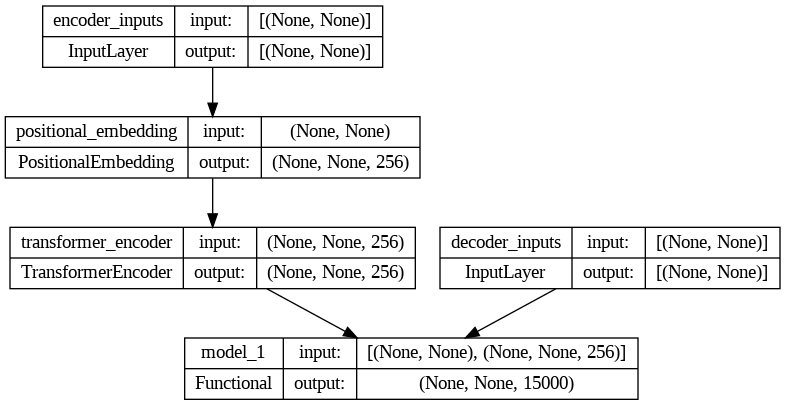

In [ ]:
tf.keras.utils.plot_model(transformer,
                          'eng_spa_translation_transformers.png',
                          show_shapes=True,
                          show_layer_activations=True)

In [ ]:
epochs = 1  # This should be at least 30 for convergence
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

1302/1302 [==============================] - 96s 68ms/step - loss: 1.6499 - accuracy: 0.4293 - val_loss: 1.2882 - val_accuracy: 0.5241


## Decoding test sentences
Finally, let's demonstrate how to translate brand new English sentences. We simply feed into the model the vectorized English sentence as well as the target token `"[start]"`, then we repeatedly generated the next token, until we hit the token `"[end]"`.

In [ ]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        print(f"==== {sampled_token}")
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]

# my_text = 'Hi, What is up? Are you doing well?'
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

==== Él
==== nunca
==== se
==== había
==== visto
==== el
==== tiempo
==== más
==== [end]
==== la
==== situación
==== es
==== la
==== de
==== la
==== vez
==== [end]
==== yo
==== creo
==== que
==== un
==== regalo
==== en
==== mi
==== habitación
==== [end]
==== no
==== puedes
==== comer
==== todo
==== el
==== tiempo
==== [end]
==== ayer
==== vi
==== a
==== mi
==== [UNK]
==== y
==== me
==== [UNK]
==== [end]
==== mi
==== padre
==== tiene
==== un
==== [UNK]
==== y
==== los
==== [UNK]
==== [end]
==== necesito
==== un
==== poco
==== [end]
==== los
==== niños
==== me
==== tienen
==== me
==== gusta
==== [end]
==== cuando
==== se
==== [UNK]
==== en
==== las
==== días
==== y
==== no
==== me
==== gusta
==== el
==== [UNK]
==== [end]
==== no
==== nos
==== nos
==== nos
==== [UNK]
==== a
==== la
==== noche
==== [end]
==== ese
==== hombre
==== no
==== me
==== dio
==== su
==== nombre
==== [end]
==== no
==== tienes
==== que
==== no
==== te
==== [UNK]
==== [end]
==== tom
==== es
==== un
==== poco
==== [end

In [ ]:
input_sentence

"I'm sorry, but I didn't know it was a secret."

In [ ]:
translated

'[start] lo siento pero no yo no había hecho un gran [UNK] [end]'

In [ ]:
decoded_sentence = "[start]"
tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
tokenized_target_sentence

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>